In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from scipy import misc
from tensorflow.keras import layers

import time
from IPython import display
# To generate GIFs
import imageio
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


In [2]:
#get training data noise to 200, Epoch to 90, kernel initializer
#(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

BATCH_SIZE = 256 #256 #64
IMG_HEIGHT = 76 #32 #76 #152 #218
IMG_WIDTH = 64 #28 #64 #124 #178
BUFFER_SIZE = 60000

#NOTE: IN TENSOR FLOW [batch,height,width,channel] height comes before width

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    #img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.dtypes.cast(img, tf.float32)
    img = (img - 127.5) / 127.5
    # resize the image to the desired size.
    return img#tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

def process_path(file_path):
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    # decode the image
    img = decode_img(img)
    return img

img_files = glob.glob('training_faces/*.jpg')[:BUFFER_SIZE]
dataset = tf.data.Dataset.from_tensor_slices(img_files)
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE
processed_dataset = dataset.map(process_path, num_parallel_calls=AUTOTUNE)

for f in processed_dataset.take(1):
    print(f.numpy().shape)

Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNextSync in device /job:localhost/replica:0/task:0/device:CPU:0
(76, 64, 3)
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0


Executing op AnonymousMemoryCache in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CacheDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousRandomSeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNextSync in device /job:localhost/replica:0/task:0/device:CPU:0


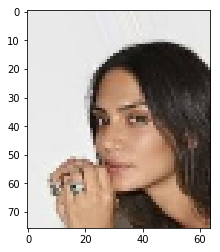

In [3]:
#[batch_size, height, width, color_channels]
#train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
# Normalize the images to [-1, 1] not sure why, we'll try 0 and 1 and see the difference
#train_images = (train_images - 127.5) / 127.5

# Batch and shuffle the data
#train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # If this is a small dataset, it only loads it once, and keeps it in memory.
    # we use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    #ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    #ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_dataset = prepare_for_training(processed_dataset,shuffle_buffer_size=BUFFER_SIZE)
image_batch = next(iter(train_dataset))
plt.imshow( (image_batch.numpy()[0] + 1) / 2.0 )

Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhos

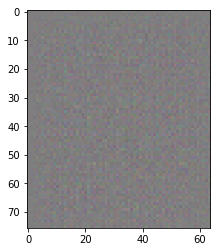

In [4]:
NOISE_SHAPE = 300
init = tf.random_normal_initializer(mean=0.0, stddev=0.02)
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(19*16*256, use_bias=False, input_shape=(NOISE_SHAPE,), kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((19, 16, 256)))
    assert model.output_shape == (None, 19, 16, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=init))
    assert model.output_shape == (None, 19, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=init))
    assert model.output_shape == (None, 38, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh', kernel_initializer=init))
    assert model.output_shape == (None, 76, 64, 3)

    return model


generator = generator_model()
generator.summary()

noise = tf.random.normal([1, NOISE_SHAPE])
generated_image = generator(noise, training=False)

plt.imshow((generated_image[0] + 1) / 2.0)

In [5]:
init = tf.random_normal_initializer(mean=0.0, stddev=0.02)
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[76, 64, 3], kernel_initializer=init))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', kernel_initializer=init))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = discriminator_model()
decision = discriminator(generated_image)
print (decision)

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Conv2D in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BiasAdd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor([[3.0185329e-05]], shape=(1, 1), dtype=float32)


In [6]:
#smoothing class=1 to [0.7, 1.2]
def smooth_positive_labels(label):
    return label - 0.3 + (tf.random.uniform(label.shape) * 0.5)
#smoothing class=0 to [0.0, 0.3]
def smooth_negative_labels(label):
    return label + (tf.random.uniform(label.shape) * 0.3)

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_label = tf.ones_like(real_output)
    fake_label = tf.zeros_like(fake_output)
    
    real_loss = cross_entropy(smooth_positive_labels(real_label), real_output)
    fake_loss = cross_entropy(smooth_negative_labels(fake_label), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [7]:
checkpoint_dir = './training_checkpoints'
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
manager = tf.train.CheckpointManager(checkpoint,checkpoint_dir, max_to_keep=3, checkpoint_name='ckpt')

In [8]:
EPOCHS = 190
noise_dim = NOISE_SHAPE
num_examples_to_generate = 9

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])
imgs_dir = './epoch_images/'

In [9]:

# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(140,epochs):
        start = time.time()
        batch_count = 0

        for image_batch in dataset:
            train_step(image_batch)
            batch_count += image_batch.numpy().shape[0]
            display.clear_output(wait=True)
            print('Batches processed {0}'.format(batch_count))
            print('Epoch: {0}'.format(epoch + 1))
            

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 10 epochs
        if (epoch + 1) % 10 == 0:
            manager.save()
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)
                            
def generate_and_save_images(model, epoch, test_input):
    # `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(3,3))

    for i in range(predictions.shape[0]):
        plt.subplot(3, 3, i+1)
        plt.imshow( (predictions[i] + 1) / 2.0)
        plt.axis('off')

    plt.savefig(imgs_dir+'image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

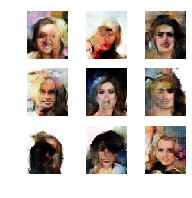

In [10]:
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

train(train_dataset, EPOCHS)

In [11]:

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(imgs_dir+'image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)


In [12]:
tf.saved_model.save(generator, "./models")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Executing op SaveV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SaveV2 in device /job:localhost/replica:0/task:0/device:CPU:0
INFO:tensorflow:Assets written to: ./models/assets
